# Phys 581 Winter 2019
# Assignment #2: Geomagnetic Bottle
## Alexander Hickey, 10169582

In [1]:
#Import useful libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.integrate
%matplotlib inline

### Introduction

The Earth's magnetic field, also known as the geomagnetic field, is wildly complex and is of great interest to space physicists. In particular, understanding how charged particles interact with the geomagnetic field is key to understanding how the Earth interacts with the solar wind.

To first order, the geomagnetic field can be approximated as a magnetic dipole. The magnetic field of a dipole in standard spherical coordinates is given by:

$$\vec B \left( \vec r \right) = \frac{\mu_0}{4\pi} \frac{M_E}{r^3} \left( 2\cos{\theta} \hat r  + \sin \theta {\hat{\theta}} \right)$$

where $M_E = 8.05 \times 10^{22} \text{ Am}^2$ is the magnetic dipole moment of the earth, and $\mu_0= 4\pi \times 10^{-7} \text{ Tm/A}$ is the permeability of free space. Working with these numbers directly is generally not a great idea, as they are many orders of magnitude different, so we will attempt to make these numbers dimensionless. We will measure all distances in units of the radius of earth $R_E = 6371 \text{ km}$. Define a base unit of magnetic flux density

$$B_0 := \frac{\mu_0}{4 \pi} \frac{M_E}{R_E^3} = 3.113\times 10^{-5} \text{ T}$$

then we can rewrite the Earth's magnetic field as 

$$\vec B= B_0 \left(\frac{R_E}{r} \right)^3\left(2 \cos \theta \hat r + \sin \theta \hat \theta \right).$$

Using the standard spherical to cartesian transformation, we have

\begin{align}
r &= \sqrt{x^2+y^2+z^2}, \qquad \cos \theta = \frac{z}{\sqrt{x^2+y^2+z^2}}, \qquad \sin \theta = \sqrt{\frac{x^2+y^2}{x^2+y^2+z^2}} \\
\hat r &= \frac{1}{\sqrt{x^2+y^2+z^2}}\left(x\hat x + y \hat y + z \hat z \right), \qquad \hat \theta = \frac{1}{\sqrt{x^2+y^2+z^2}}\left(x\hat x + y \hat y + z \hat z \right) \\
\end{align}

so the dipole magnetic field in cartesian coordinates is 

$$\vec B= B_0 \frac{R_E^3}{(x^2+y^2+z^2)^{5/2}} \left[ 3xz \hat x + 3yz \hat y + \left( 2z^2-x^2-y^2 \right) \hat z \right].$$

A particle of charge $q$ will then experience a force governed by the Lorentz force law 

$$\vec F = q \vec v \times \vec B$$

In this notebook, we will consider the motion of a proton ($q=e$) through the Earth's magnetic field. In this case, the equations of motion are given by 

$$\vec a = \frac{e}{m} \vec v \times \vec B.$$

The physical parameters of interest are therefore the radius of the earth $R_E$, the magnetic flux density $B_0$, and the charge and mass of a proton $e=1.60217662 \times 10^{-19} \text{ C}$, $m=1.6726219  \times 10^{-27} \text{ kg}$. Since the physical parameters at play vary greatly in order of magnitude, it is a good idea to make the equations of motion dimensionless. These dimensionless equations are readily obtained by noting that 

$$t_0 := \frac{m}{eB_0} = 3.353577 \times 10^{-4} \text{ s}$$

has units of time, so I will take this to be the characteristic time scale. Defining a dimensionless time $\tau:= t/t_0$, position $\vec \rho := \vec r/R_E$, magnetic field $\vec \beta := \vec B/B_0$, and velocity 

$$\vec \nu = \frac{d \vec{\rho}}{d\tau} = \frac{t_0}{R_E} \vec v$$

the equations of motion simplify to 

$$\frac{d \vec \nu}{d\tau} = \vec \nu \times \vec \beta$$

where it is understoon that lengths are now measured in units of $R_E$, and time in units of $t_0$.

##### Task: 

Read  https://www2.mps.mpg.de/solar-system-school/lectures/space_plasma_physics_2007/Lecture_3.pdf and then numerically integrate the motion of a $T = 1\text{ keV}$ proton starting at the surface of the Earth ($r=6371 \text{km}$) with latitude $66^\circ$ moving antiparallel to the local $\vec B$.

We begin by defining the parameters relevant to this problem. Given an initial kinetic energy of $T$, the initial speed will be $v_0 = \sqrt{2T/m}$, so the initial dimensionless speed will be 

$$\nu_0 = \frac{t_0}{R_E}v_0 = \frac{t_0}{R_E} \sqrt{2T/m} = 2.3039 \times 10^{-5}$$

In [2]:
t0 = 3.353577e-4 #Characteristic time in seconds
B0 = 3.113e-5 #Magnetic flux density of earth in T
v0 = 2.3039e-5 #Initial dimensionless speed
Lat = 66 #Initial latitude in degrees

Next, several functions are defined to compute the initial conditions in spherical coordinates, as well as to define the system of differential equations to be integrated. Although the equations of motion as written are second order in position, they can be readily converted to a system of twice as many first order equations by rewriting them as 

\begin{align}
\frac{d\vec \nu}{d\tau} &= \vec \nu \times \vec \beta \\
\frac{d \vec \rho}{d\tau} &= \vec \nu.
\end{align}

In [5]:
def B(x,y,z):
    '''
    This function defines the geomagnetic field vector in cartesian
    coordinates using the dipole approximation.
    
    Args:
        x: float, x component of position
        y: float, y component of position
        z: float, z component of position
        
    Return:
        B: array, Magnetic field components in the form [Bx,By,Bz].
    '''
    
    #Common factor to each component, no need to compute 3 times
    scale = scale = 1/(x*x+y*y+z*z)**(5/2)
    
    #Define each component
    Bx = 3.0*x*z
    By = 3.0*y*z
    Bz = 2.0*z*z-x*x-y*y
    
    return np.array([Bx,By,Bz])*scale


def sphere_to_cart(rtp):
    '''
    This function converts an array of standard spherical coordinates to cartesian coordinates.
    
    Args:
        rtp: Array of the form [r,theta,phi] with theta the polar angle.
        
    Return:
        xyz: Array of cartesian coordinates [x,y,z]
    '''
    
    xyz = np.zeros(rtp.shape)
    
    xyz[0] = rtp[0]*np.sin(rtp[1])*np.cos(rtp[2])
    xyz[1] = rtp[0]*np.sin(rtp[1])*np.sin(rtp[2])
    xyz[2] = rtp[0]*np.cos(rtp[1])
    
    return xyz


def time_evol(t,state):
    '''
    This function defines the time evolution of a proton in the geomagnetic dipole field.
    
    Args:
        t: Time to evaluate system
        state: Input state of the form [vx,vy,vx,x,y,z]
        
    Return:
        newstate: Time derivative of [vx,vy,vx,x,y,z]
    '''
    
    #Create output array
    newstate = np.zeros(state.shape)
    
    #Unpack input state
    x,y,z = state[3:]
    
    #Define time derivative of each component
    newstate[:3] = np.cross(state[:3],B(x,y,z))
    newstate[3:] = state[:3]
    
    return newstate

The dipole approximation of the geomagnetic field can be nicely visualized using a streamplot.

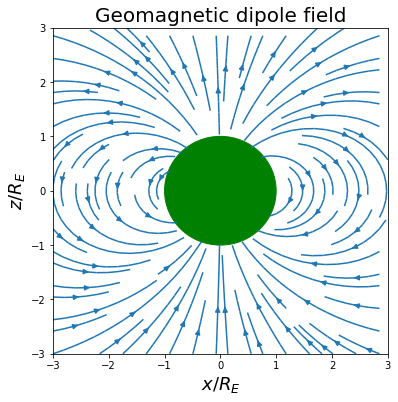

In [6]:
#Compute magnetic field vectors in the xz plane
x, y, z = np.linspace(-3,3,100), 0.0 , np.linspace(-3,3,100)
xx,zz = np.meshgrid(x,z)
Bx, By, Bz = B(xx,y,zz)

#Mask to delete points within the earth
mask = xx**2+zz**2 > 1

#Plot dipole field as streamplot
fig, ax = plt.subplots(figsize = (6,6))
ax.streamplot(x, z, Bx*mask, Bz*mask)
ax.set_xlabel('$x/R_E$',fontsize=18)
ax.set_ylabel('$z/R_E$',fontsize=18)
ax.set_title('Geomagnetic dipole field',fontsize=20)

#Plot a circle to represent the Earth
circ = plt.Circle((0, 0), radius=1, edgecolor='green', facecolor='green')
ax.add_patch(circ)

plt.show()

We see that the magnetic field function reproduces what we would expect of a perfect dipole. The starting point of the proton is given as being at the surface of the earth with a latitude of $66^\circ$, which corresponds to a polar angle of $\theta = 90^\circ-66^\circ = 24^\circ$ in standard spherical coordinates. Additionally, we know the initial velocity is antiparallel to the local magnetic field, so $\vec \nu = -\nu_0 \vec B / |\vec B|$.

In [8]:
#Initialize state vector
state0 = np.zeros(6)

#Convert initial conditions to cartesian coordinates (phi is arbitrary)
r,theta,phi = 1.0, (90-Lat)*np.pi/180, 0.0
x0,y0,z0 = sphere_to_cart(np.array([r,theta,phi]))

#Compute local magnetic field and initial velocity
B0vec = B(x0,y0,z0)
v0vec = -v0*B0vec/np.linalg.norm(B0vec)

#Define inital state
state0[:3], state0[3:] = v0vec, [x0, y0, z0]

Next we simply integrate the equations of motion to find the trajectory. I will use the scipy.integrate.solve_ivp function, which by default uses the RK45 method to dynamically compute time steps to stay within some tolerance.

In [16]:
#Define time interval and integrate
t_span = (0,5e5)
dat = scipy.integrate.solve_ivp(time_evol,t_span,state0,rtol=1e-13)

#Extract time, position and velocity arrays
time = dat.t
[x,y,z] = dat.y[3:]
[vx,vy,vz] = dat.y[:3]

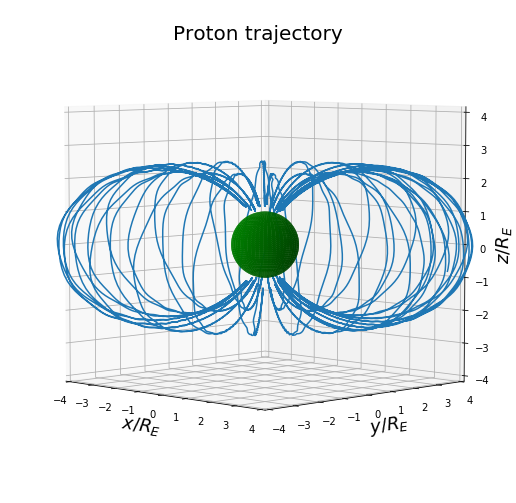

In [61]:
#Plot trajectory in 3D
fig = plt.figure(figsize=(9,9))
ax = fig.gca(projection='3d')
ax.plot3D(x,y,z)

ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.set_zlim(-4, 4)
ax.set_xlabel('$x/R_E$',fontsize=18)
ax.set_ylabel('$y/R_E$',fontsize=18)
ax.set_zlabel('$z/R_E$',fontsize=18)
ax.set_title('Proton trajectory',fontsize=20)
ax.view_init(5,-45)

#Overlay unit sphere to represent earth
u, v = np.linspace(0, 2 * np.pi, 100), np.linspace(0, np.pi, 100)
xc = np.outer(np.cos(u), np.sin(v))
yc = np.outer(np.sin(u), np.sin(v))
zc = np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_surface(xc, yc, zc, color='g')

plt.show()

##### Task: 
Does you result look like the plot in slide#7?  If not, what values (eg. energy, pitch angle, latitude) produce a better resemblance?

As expected, we see that the long term trajectory includes the bounce motion, as well as the drift motion. Contrary to the diagram in the resource provided, it is not clear if there are gyrations in the trajectory. To see this, I will zoom in on the trajectory over the first bounce period.

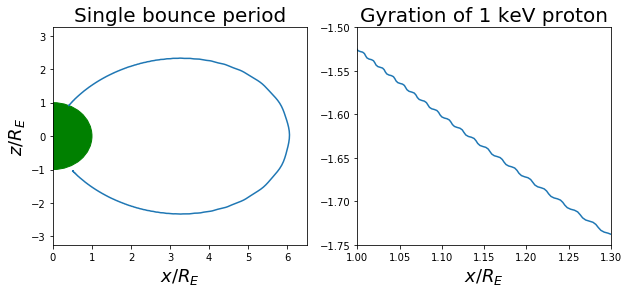

In [84]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

#Plot first bounce period
ax[0].plot(x[:3900],z[:3900])
ax[0].set_xlim(0,6.5)
ax[0].set_ylim(-3.25,3.25)
ax[0].set_xlabel('$x/R_E$',fontsize=18)
ax[0].set_ylabel('$z/R_E$',fontsize=18)
ax[0].set_title('Single bounce period',fontsize=20)
circ = plt.Circle((0, 0), radius=1, edgecolor='green', facecolor='green')
ax[0].add_patch(circ)

#Zoom in to small region of trajectory
ax[1].plot(x[3000:3150],z[3000:3150])
ax[1].set_xlim(1,1.3)
ax[1].set_ylim(-1.75,-1.5)
ax[1].set_xlabel('$x/R_E$',fontsize=18)
ax[1].set_title('Gyration of 1 keV proton',fontsize=20)

plt.show()

Zooming in, we see that the integrater was precise enough to pick up these gyrations. These gyrations however, are so small compared to the trajectory as a whole that they are not visible when plotting the entire curve. In order to reproduce the plot in slide 7, we need to vary the initial conditions. Recall that for a uniform magnetic field $B$, a proton will undergo uniform circular motion with a radius $r = mv/eB\sin \Theta$ where $\Theta$ is the angle between the magnetic field and the velocity vector. Although the field we're considering is not uniform, this formula gives us some insight into how we can increase the radius of gyration, namely, increase the initial speed. Additionally, although the gyration radius will decrease with an increased pitch angle, this will result in a trajectore which doesn't go as far in the x-direction, thus making the gyrations more pronounced relative to the rest of the path. Finally, decreasing the lattitude will have the same effect (i.e. shorter trajectory), so starting closer to the equator should also make the gyrations more pronounced.

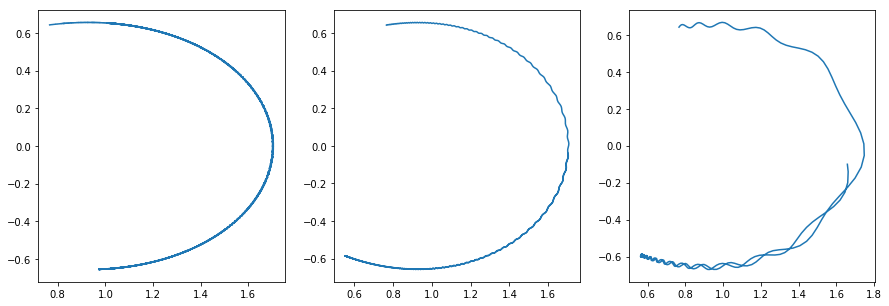

In [122]:
#Rescale initial speed by various factors
scl = [1e1,1e2,1e3]
tbnd = [23000,2300,230]

#Plot trajectory of various initial speeds
fig, ax = plt.subplots(1,3,figsize=(15,5))

for j in range(len(scl)):
    #Initialize state vector
    s0 = np.zeros(6)

    #Convert initial conditions to cartesian coordinates (phi is arbitrary)
    r,theta,phi = 1.0, (90-40)*np.pi/180, 0.0
    x0,y0,z0 = sphere_to_cart(np.array([r,theta,phi]))

    #Compute local magnetic field and initial velocity
    Bvec = B(x0,y0,z0)
    Bvec[2] = 5*Bvec[2]
    vvec = scl[j]*v0*B0vec/np.linalg.norm(B0vec)

    #Define inital state
    s0[:3], s0[3:] = vvec, [x0, y0, z0]
    
    dat_scl = scipy.integrate.solve_ivp(time_evol,(0,tbnd[j]),s0,rtol=1e-13)
    xs, ys, zs = dat_scl.y[3:]
    ax[j].plot(xs,zs)

(0, 300)

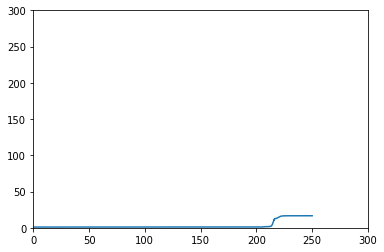

In [15]:
Tlist = m/2*(dat.y[0]**2+dat.y[1]**2+dat.y[2]**2)/T
plt.plot(dat.t,Tlist)

plt.ylim(0,300)
plt.xlim(0,300)

Lat = 50, T = 1GEV, pitch 5x larger in z